In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jul 28 21:22:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 52%   83C    P2   227W / 250W |   3046MiB / 11019MiB |     89%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 20

# Name is the output file name


##  200719  mds
folder = '28July2020_Trks_to_KDE_B_200epochs_3m5'
name = '28July2020_Trks_to_KDE_B_200epochs_3m5'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 3e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_kde import collect_t2kde_data

# From model/loss.py
##from loss import Loss
from model.kde_loss_A import Loss


from model.models_kde import TracksToKDE_C as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(1)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:

## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                           device=device,
                           slice = slice(None,5)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(5,10)
                           )

Loading data...
len(X) =  100
len(Xlist) =  1
Loaded /share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5 in 0.08274 s
outer loop X.shape =  (100, 6, 600)
Constructing 5 event dataset took 1.867 s
x_t.shape =  torch.Size([5, 6, 600])
x_t.shape[0] =  5
x_t.shape[1] =  6
x_t.shape =  torch.Size([5, 6, 600])
Loading data...
len(X) =  100
len(Xlist) =  1
Loaded /share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5 in 0.04089 s
outer loop X.shape =  (100, 6, 600)
Constructing 5 event dataset took 0.001262 s
x_t.shape =  torch.Size([5, 6, 600])
x_t.shape[0] =  5
x_t.shape[1] =  6
x_t.shape =  torch.Size([5, 6, 600])


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
loss = Loss(epsilon=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=6, out_features=12, bias=False)
ct, child =  1    Linear(in_features=12, out_features=15, bias=False)
ct, child =  2    Linear(in_features=15, out_features=4000, bias=False)


In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
##pretrained_dict = torch.load('ML/Aug17_FourFeature_CNN6LayerPlus_TargetsAA_Loss_A_1p0_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/28July2020_Trks_to_KDE_B_200epochs_3m5
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer2.weight
index, k =   2    layer3.weight
 
   for pretrained_dict
model_dict instantiated


In [13]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [14]:
model = model.to(device)

train_loader =  <torch.utils.data.dataloader.DataLoader object at 0x7f705560bf50>
inputs.shape =  torch.Size([5, 6, 600])
in forward, x.shape =  torch.Size([5, 6, 600])
nEvts =  5    nFeatures =  6   nTrks =  600
filt.shape =  torch.Size([5, 600])
f1.shape =  torch.Size([5, 600, 1]) f2.shape =  torch.Size([5, 600, 4000])
after transpose, x.shape =  torch.Size([5, 600, 6])
after softplus, x.shape =  torch.Size([5, 600, 4000])
y_pred.shape =  torch.Size([5, 4000])
x1.shape =  torch.Size([5, 600, 4000])
y_prime.shape =  torch.Size([5, 4000])
y_pred[:,0:10] =   tensor([[ 190.6746,  244.8506,  180.4216,  176.7913, 1381.0291, 3426.2620,
          632.3262, 1716.1417,  305.5732, 2943.3901],
        [ 178.1994,  234.8820,  167.5160,  163.4666, 1434.4697, 3592.3711,
          644.1446, 1787.9702,  299.1940, 3082.5398],
        [ 252.9702,  292.2085,  245.4690,  242.3646, 1116.5264, 2598.1829,
          573.7369, 1359.0254,  335.3868, 2248.8208],
        [ 142.5109,  207.7046,  130.8543,  126.29

<IPython.core.display.Javascript object>


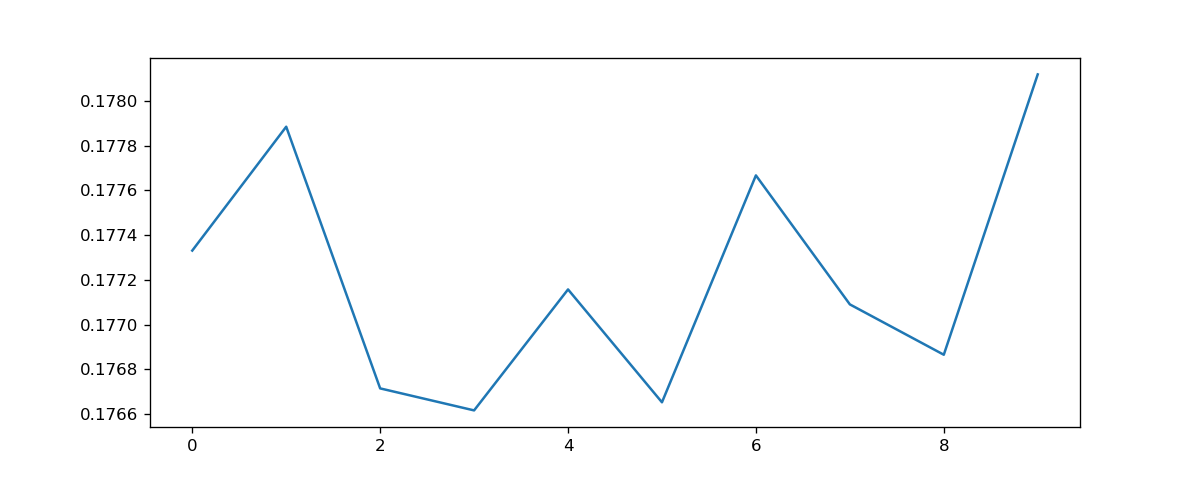

  point AA 
features.shape =  torch.Size([1, 6, 600])
in forward, x.shape =  torch.Size([1, 6, 600])
nEvts =  1    nFeatures =  6   nTrks =  600
filt.shape =  torch.Size([1, 600])
f1.shape =  torch.Size([1, 600, 1]) f2.shape =  torch.Size([1, 600, 4000])
after transpose, x.shape =  torch.Size([1, 600, 6])
after softplus, x.shape =  torch.Size([1, 600, 4000])
y_pred.shape =  torch.Size([1, 4000])
x1.shape =  torch.Size([1, 600, 4000])
y_prime.shape =  torch.Size([1, 4000])
y_pred[:,0:10] =   tensor([[ 190.6746,  244.8506,  180.4216,  176.7913, 1381.0291, 3426.2620,
          632.3260, 1716.1418,  305.5732, 2943.3906]], device='cuda:0')
y_prime[:,0:10] =   tensor([[177.3309, 177.8841, 176.7153, 176.6170, 177.1573, 176.6532, 177.6667,
         177.0906, 176.8657, 178.1178]], device='cuda:0')


<IPython.core.display.Javascript object>


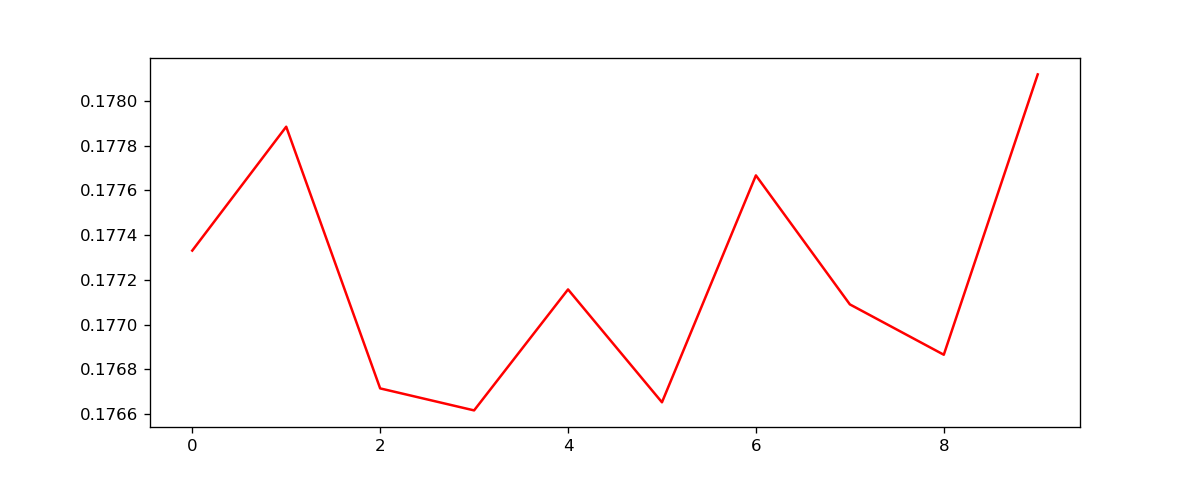

<IPython.core.display.Javascript object>


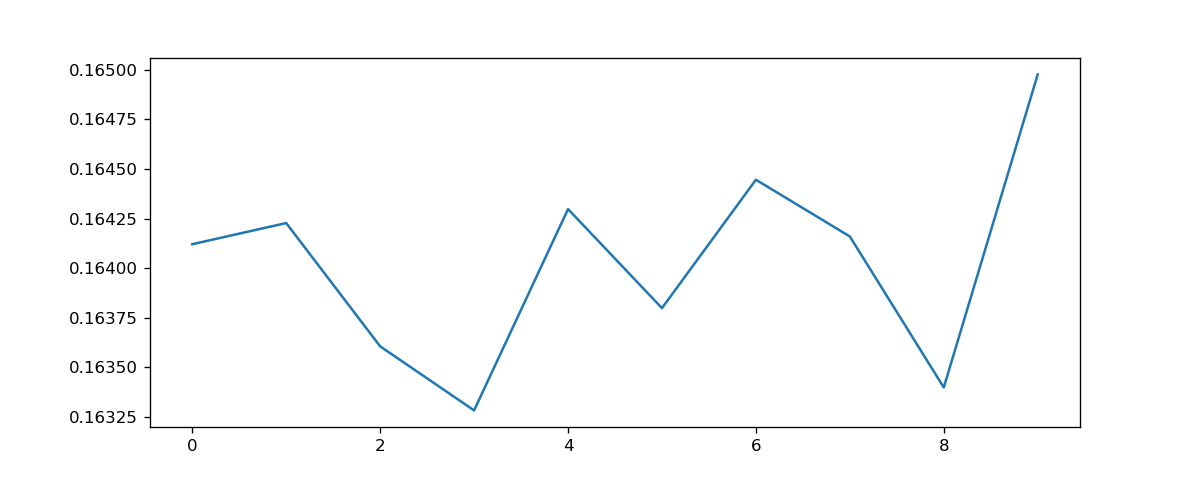

  point AA 
features.shape =  torch.Size([1, 6, 600])
in forward, x.shape =  torch.Size([1, 6, 600])
nEvts =  1    nFeatures =  6   nTrks =  600
filt.shape =  torch.Size([1, 600])
f1.shape =  torch.Size([1, 600, 1]) f2.shape =  torch.Size([1, 600, 4000])
after transpose, x.shape =  torch.Size([1, 600, 6])
after softplus, x.shape =  torch.Size([1, 600, 4000])
y_pred.shape =  torch.Size([1, 4000])
x1.shape =  torch.Size([1, 600, 4000])
y_prime.shape =  torch.Size([1, 4000])
y_pred[:,0:10] =   tensor([[ 178.1994,  234.8820,  167.5160,  163.4666, 1434.4697, 3592.3711,
          644.1445, 1787.9705,  299.1940, 3082.5403]], device='cuda:0')
y_prime[:,0:10] =   tensor([[164.1208, 164.2275, 163.6057, 163.2827, 164.2980, 163.7984, 164.4459,
         164.1598, 163.3983, 164.9772]], device='cuda:0')


<IPython.core.display.Javascript object>


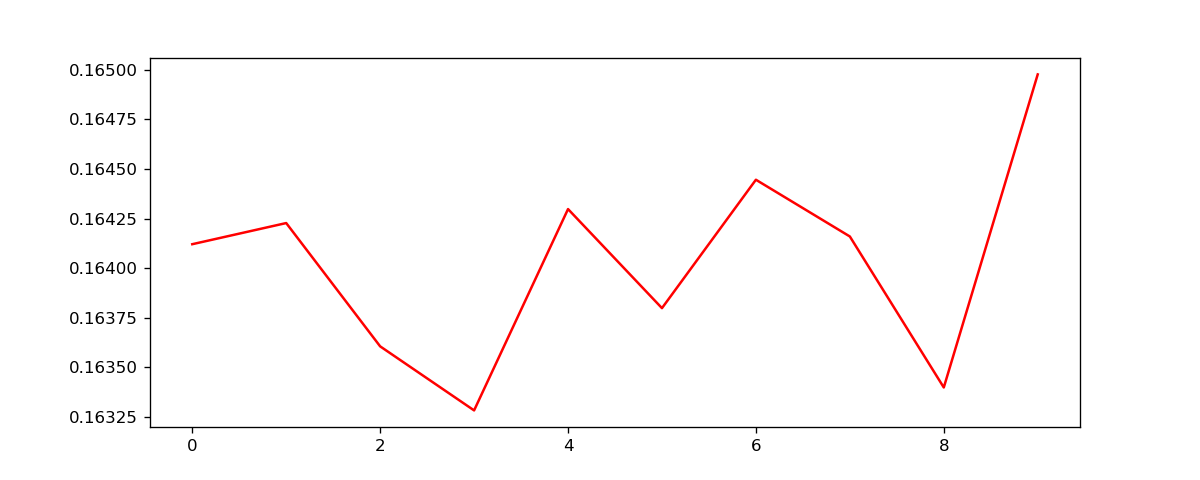

<IPython.core.display.Javascript object>


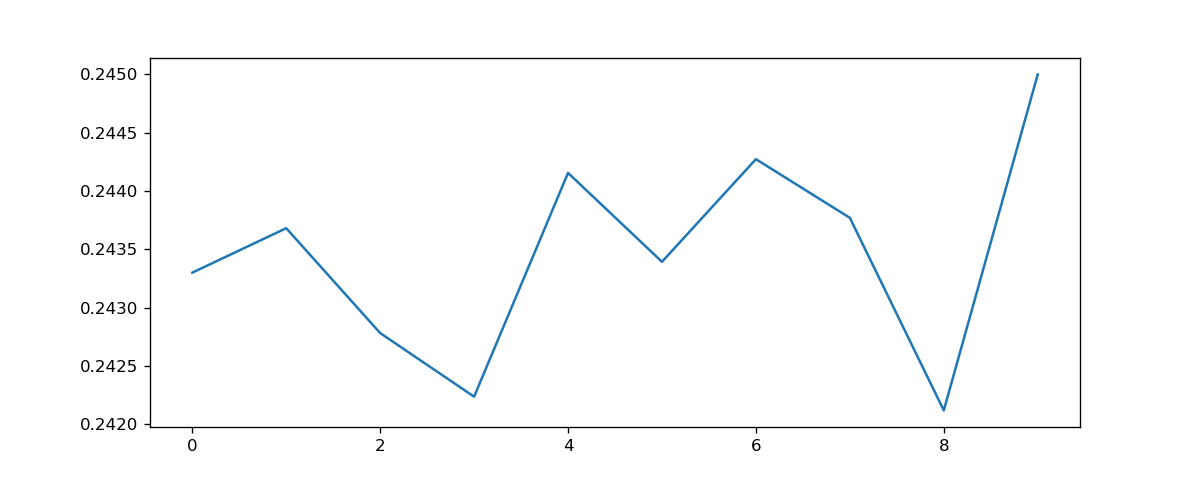

  point AA 
features.shape =  torch.Size([1, 6, 600])
in forward, x.shape =  torch.Size([1, 6, 600])
nEvts =  1    nFeatures =  6   nTrks =  600
filt.shape =  torch.Size([1, 600])
f1.shape =  torch.Size([1, 600, 1]) f2.shape =  torch.Size([1, 600, 4000])
after transpose, x.shape =  torch.Size([1, 600, 6])
after softplus, x.shape =  torch.Size([1, 600, 4000])
y_pred.shape =  torch.Size([1, 4000])
x1.shape =  torch.Size([1, 600, 4000])
y_prime.shape =  torch.Size([1, 4000])
y_pred[:,0:10] =   tensor([[ 252.9702,  292.2085,  245.4690,  242.3646, 1116.5264, 2598.1829,
          573.7369, 1359.0255,  335.3868, 2248.8208]], device='cuda:0')
y_prime[:,0:10] =   tensor([[243.3009, 243.6820, 242.7834, 242.2383, 244.1556, 243.3940, 244.2736,
         243.7709, 242.1205, 245.0001]], device='cuda:0')


<IPython.core.display.Javascript object>


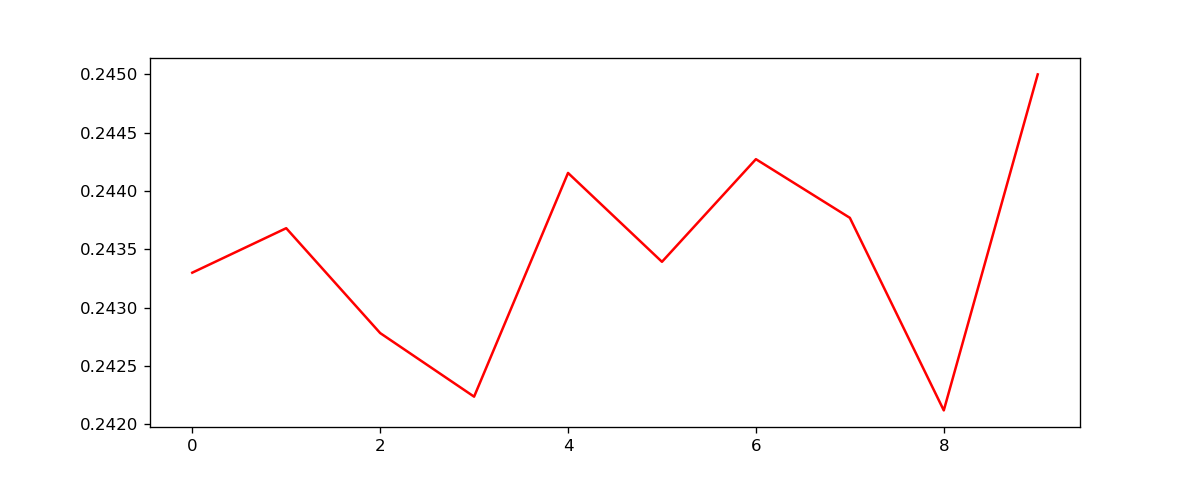

<IPython.core.display.Javascript object>


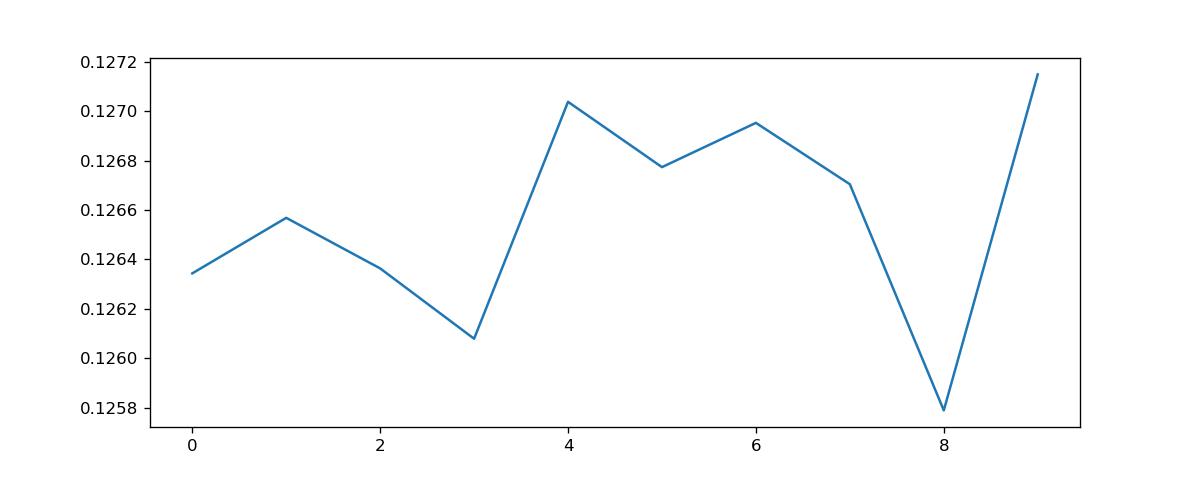

  point AA 
features.shape =  torch.Size([1, 6, 600])
in forward, x.shape =  torch.Size([1, 6, 600])
nEvts =  1    nFeatures =  6   nTrks =  600
filt.shape =  torch.Size([1, 600])
f1.shape =  torch.Size([1, 600, 1]) f2.shape =  torch.Size([1, 600, 4000])
after transpose, x.shape =  torch.Size([1, 600, 6])
after softplus, x.shape =  torch.Size([1, 600, 4000])
y_pred.shape =  torch.Size([1, 4000])
x1.shape =  torch.Size([1, 600, 4000])
y_prime.shape =  torch.Size([1, 4000])
y_pred[:,0:10] =   tensor([[ 142.5109,  207.7046,  130.8543,  126.2907, 1585.6414, 4063.9805,
          677.8149, 1991.4099,  281.7310, 3477.5366]], device='cuda:0')
y_prime[:,0:10] =   tensor([[126.3437, 126.5683, 126.3638, 126.0795, 127.0374, 126.7733, 126.9523,
         126.7042, 125.7897, 127.1483]], device='cuda:0')


<IPython.core.display.Javascript object>


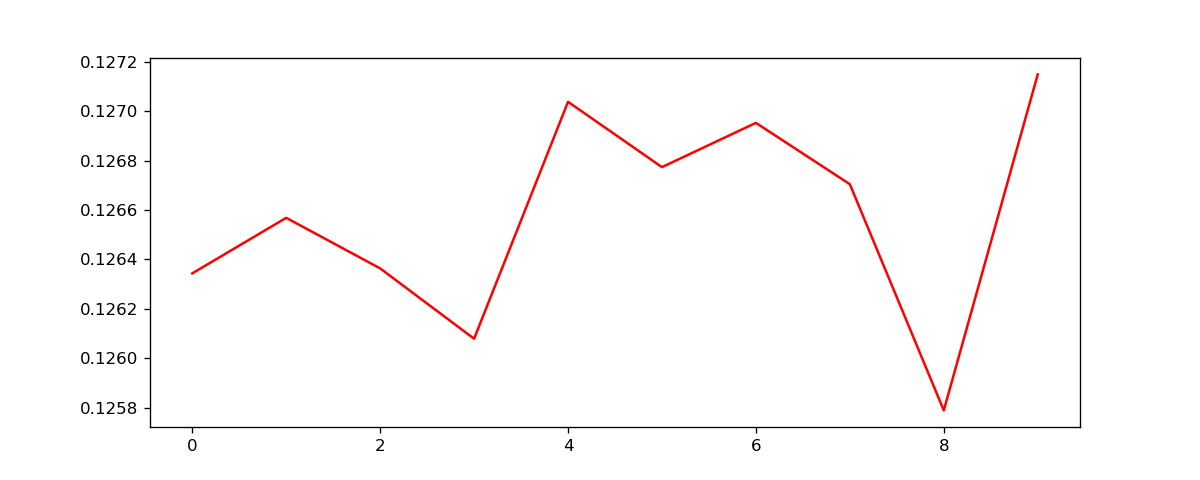

nEvts =  5


In [15]:
with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:10])
                plt.show()
                
                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:10], color="r")
                plt.show()
                
            

        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

Go ahead and save the final model (even though it was also saved above):

Save the output results:

Save the plot above: